# Global Covid-19 Forecasting using Machine Learning

## Mục tiêu
Xây dựng mô hình dự báo số ca nhiễm Covid-19 hằng ngày cho **toàn bộ quốc gia**
dựa trên dữ liệu chuỗi thời gian.

## Mô hình sử dụng
- Linear Regression
- Random Forest Regressor
- XGBoost Regressor

## Đặc trưng đầu vào
- lag_1: số ca ngày hôm trước
- lag_7: số ca 7 ngày trước
- rolling_mean_7: trung bình 7 ngày gần nhất
- Rolling_Slope_7
- Rolling_Std_7
- Cluster

## Chỉ số đánh giá
- MAE
- RMSE
- MAPE

## 1. Import Libraries


In [56]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error


## 2. Load Dataset

The dataset already includes clustering results (K-Means)
and rolling epidemiological indicators.

In [57]:
df = pd.read_csv("../data/processed/timeseries_with_clusters.csv")
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

df.sort_values(['Country', 'Date_reported'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths,New_cases_MA7,New_deaths_MA7,Growth_Rate,Cluster
0,2020-01-04,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
1,2020-01-05,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
2,2020-01-06,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
3,2020-01-07,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
4,2020-01-08,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1


## 3. Feature Engineering

We construct features reflecting:
- **Temporal dependency** (lags)
- **Trend** (rolling mean & slope)
- **Volatility** (rolling std)
- **Structural similarity** (Cluster)


In [58]:
def add_features(group):
    group = group.copy()
    
    group['lag_1'] = group['New_cases_MA7'].shift(1)
    group['lag_7'] = group['New_cases_MA7'].shift(7)
    
    group['Rolling_Mean_7'] = group['New_cases_MA7'].shift(1).rolling(7).mean()
    group['Rolling_Std_7'] = group['New_cases_MA7'].shift(1).rolling(7).std()
    
    # Rolling slope (trend strength)
    group['Rolling_Slope_7'] = (
        group['New_cases_MA7'].shift(1)
        .rolling(7)
        .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=False)
    )
    
    return group

df = df.groupby('Country').apply(add_features)
df.dropna(inplace=True)
df.head()

C:\Users\antrn\AppData\Local\Temp\ipykernel_2328\899988681.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Country').apply(add_features)


Date_reported Country_code      Country WHO_region  New_cases  \
Country                                                                        
Afghanistan 7     2020-01-11           AF  Afghanistan        EMR        0.0   
            8     2020-01-12           AF  Afghanistan        EMR        0.0   
            9     2020-01-13           AF  Afghanistan        EMR        0.0   
            10    2020-01-14           AF  Afghanistan        EMR        0.0   
            11    2020-01-15           AF  Afghanistan        EMR        0.0   

                New_deaths  Cumulative_cases  Cumulative_deaths  \
Country                                                           
Afghanistan 7          0.0                 0                  0   
            8          0.0                 0                  0   
            9          0.0                 0                  0   
            10         0.0                 0                  0   
            11         0.0                 0                  0   

                New_cases_MA7  New_deaths_MA7  Growth_Rate  Cluster  lag_1  \
Country                                                                      
Afghanistan 7             0.0             0.0          0.0        1    0.0   
            8             0.0             0.0          0.0        1    0.0   
            9             0.0             0.0          0.0        1    0.0   
            10            0.0             0.0          0.0        1    0.0   
            11            0.0             0.0          0.0        1    0.0   

                lag_7  Rolling_Mean_7  Rolling_Std_7  Rolling_Slope_7  
Country                                                                
Afghanistan 7     0.0             0.0            0.0              0.0  
            8     0.0             0.0            0.0              0.0  
            9     0.0             0.0            0.0              0.0  
            10    0.0             0.0            0.0              0.0  
            11    0.0             0.0            0.0              0.0

In [60]:
# 1. Tính ma trận tương quan
corr_matrix = df.corr(numeric_only=True)

# 2. Lấy riêng tương quan của các biến với 'New_cases_MA7'
# Sắp xếp giảm dần để thấy biến nào có tác động mạnh nhất
target_corr = corr_matrix['New_cases_MA7'].sort_values(ascending=False)

print("Độ tương quan với New_cases_MA7:")
print(target_corr)


Độ tương quan với New_cases_MA7:
New_cases_MA7        1.000000
lag_1                0.996710
New_cases            0.963411
Rolling_Mean_7       0.954979
lag_7                0.870296
Rolling_Std_7        0.748565
New_deaths_MA7       0.375748
New_deaths           0.363942
Rolling_Slope_7      0.281678
Cumulative_cases     0.166934
Cumulative_deaths    0.132836
Growth_Rate         -0.001421
Cluster             -0.003660
Name: New_cases_MA7, dtype: float64


In [50]:
df.to_csv('data_with_features.csv', index=False, encoding='utf-8-sig')

## 4. Define Training and Test Periods

- **Train**: all data until 2022-12-31  
- **Test**: first 7 & 14 days of 2023


In [59]:
FEATURES = [
    'lag_1', 'lag_7',
    'Rolling_Mean_7', 'Rolling_Slope_7',
    'Rolling_Std_7',
    'Cluster'
]

TARGET = 'New_cases_MA7'

train_df = df[df['Date_reported'] <= '2022-12-31']
test_df = df[
    (df['Date_reported'] >= '2023-01-01') &
    (df['Date_reported'] <= '2023-01-14')
]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

dates_test = test_df['Date_reported']


## 5. Model Initialization

We compare three models with increasing non-linearity:
1. Linear Regression (baseline)
2. Random Forest (non-linear ensemble)
3. XGBoost (boosted trees)


In [61]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        objective='reg:squarederror',
        random_state=42
    )
}

predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

global_rf_model = models["Random Forest"]
global_ln_model = models["Linear Regression"]
global_xgb_model = models["XGBoost"]

## 6. Evaluation Metrics

We evaluate performance at:
- 7-day horizon
- 14-day horizon

Metrics:
- MAE
- RMSE
- MAPE (interpreted with caution)


In [62]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(
        np.abs((y_true - y_pred) / np.maximum(y_true, 1))
    ) * 100
    return mae, rmse, mape


In [63]:
results = []

for name, y_pred in predictions.items():
    for h in [7, 14]:
        mae, rmse, mape = calculate_metrics(
            y_test.iloc[:h],
            y_pred[:h]
        )
        results.append({
            "Model": name,
            "Horizon (days)": h,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape
        })

results_df = pd.DataFrame(results)
results_df


,Model,Horizon (days),MAE,RMSE,MAPE (%)
0,Linear Regression,7,13.103180,13.975790,42.465610
1,Linear Regression,14,9.741519,11.460681,33.747959
2,Random Forest,7,5.422441,7.010323,18.931054
3,Random Forest,14,5.209058,6.383484,18.891362
4,XGBoost,7,11.413527,12.661905,38.236145
5,XGBoost,14,11.504166,12.267340,41.444294


## 7. Visualization: Actual vs Predicted (Early 2023)


In [64]:
# Gắn prediction vào test_df
plot_df = test_df.copy()

plot_df["Pred_LR"] = predictions["Linear Regression"]
plot_df["Pred_RF"] = predictions["Random Forest"]
plot_df["Pred_XGB"] = predictions["XGBoost"]

# Aggregate theo ngày (GLOBAL)
agg = plot_df.groupby("Date_reported").agg({
    "New_cases_MA7": "sum",
    "Pred_LR": "sum",
    "Pred_RF": "sum",
    "Pred_XGB": "sum"
}).reset_index()


### HÌNH 1 — MAE comparison (7 & 14 ngày)

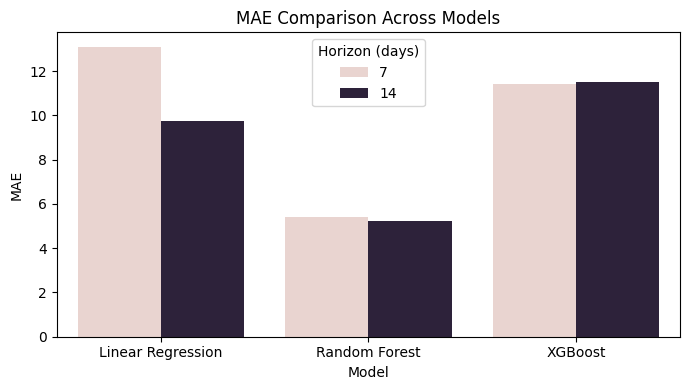

In [65]:
import seaborn as sns

plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="Model", y="MAE", hue="Horizon (days)")
plt.title("MAE Comparison Across Models")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()


### HÌNH 2 — RMSE comparison

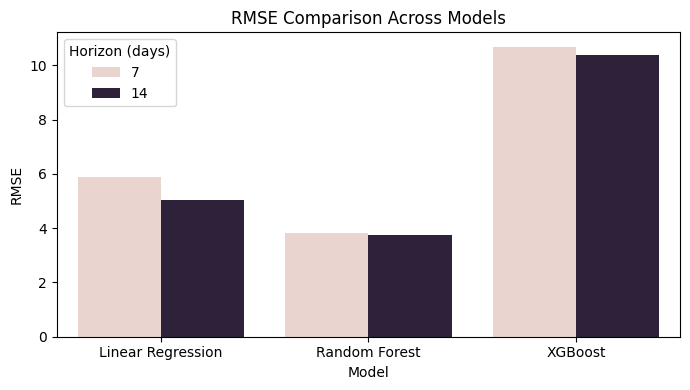

In [45]:
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="Model", y="RMSE", hue="Horizon (days)")
plt.title("RMSE Comparison Across Models")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


### HÌNH 3 — MAPE comparison

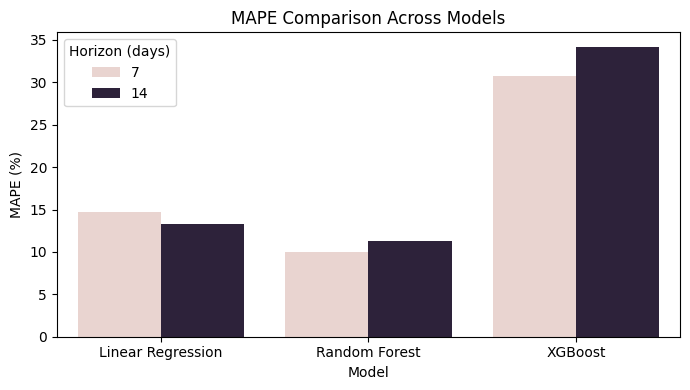

In [31]:
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="Model", y="MAPE (%)", hue="Horizon (days)")
plt.title("MAPE Comparison Across Models")
plt.ylabel("MAPE (%)")
plt.tight_layout()
plt.show()


### HÌNH 4 — Heatmap MAE (Executive summary)

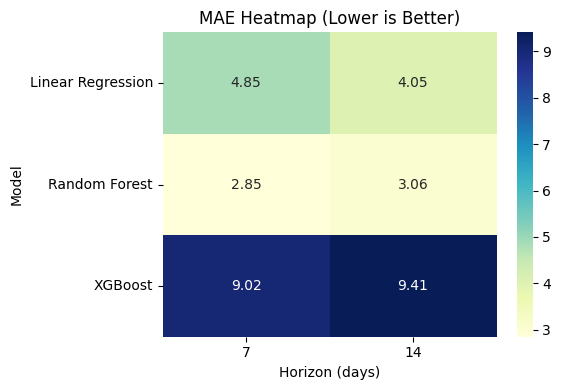

In [32]:
pivot = results_df.pivot(
    index="Model",
    columns="Horizon (days)",
    values="MAE"
)

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("MAE Heatmap (Lower is Better)")
plt.tight_layout()
plt.show()


### HÌNH 6 — So sánh 3 mô hình (GLOBAL)

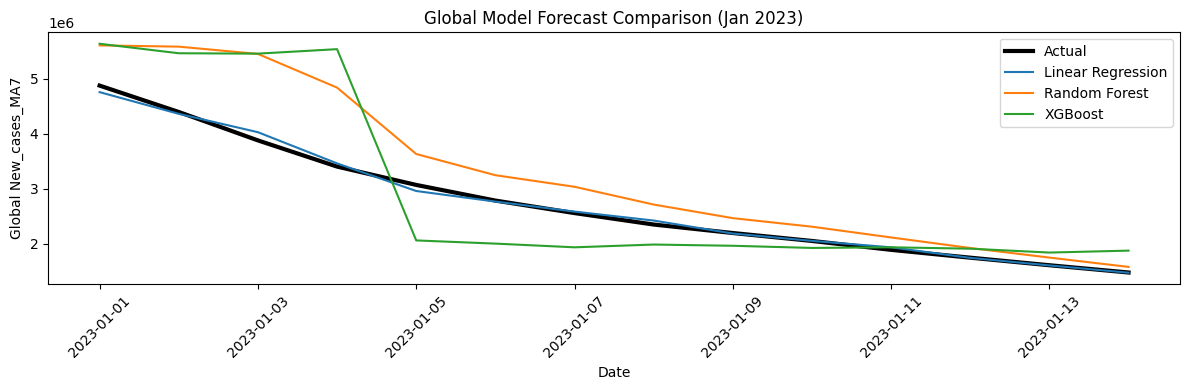

In [66]:
plt.figure(figsize=(12,4))
plt.plot(agg["Date_reported"], agg["New_cases_MA7"],
         label="Actual", linewidth=3, color="black")

plt.plot(agg["Date_reported"], agg["Pred_LR"], label="Linear Regression")
plt.plot(agg["Date_reported"], agg["Pred_RF"], label="Random Forest")
plt.plot(agg["Date_reported"], agg["Pred_XGB"], label="XGBoost")

plt.title("Global Model Forecast Comparison (Jan 2023)")
plt.xlabel("Date")
plt.ylabel("Global New_cases_MA7")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### HÌNH 5 — Actual vs Random Forest (GLOBAL)

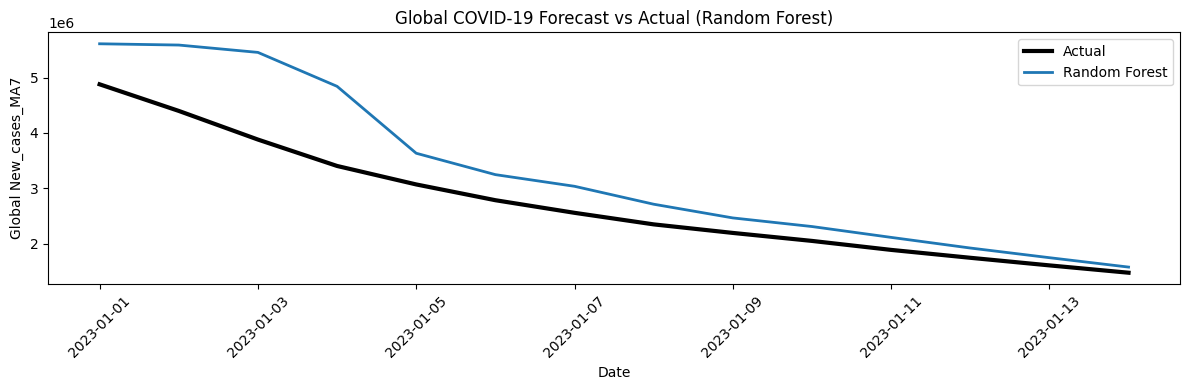

In [67]:
plt.figure(figsize=(12,4))
plt.plot(agg["Date_reported"], agg["New_cases_MA7"],
         label="Actual", linewidth=3, color="black")
plt.plot(agg["Date_reported"], agg["Pred_RF"],
         label="Random Forest", linewidth=2)

plt.title("Global COVID-19 Forecast vs Actual (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Global New_cases_MA7")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### HÌNH 7 — Residual theo thời gian (Random Forest)

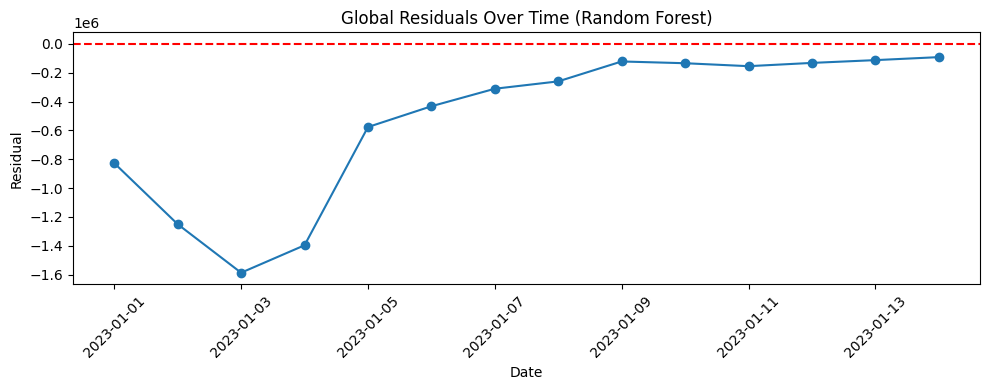

In [35]:
agg["Residual_RF"] = agg["New_cases_MA7"] - agg["Pred_RF"]

plt.figure(figsize=(10,4))
plt.plot(agg["Date_reported"], agg["Residual_RF"], marker='o')
plt.axhline(0, color='red', linestyle='--')

plt.title("Global Residuals Over Time (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### HÌNH 8 — Rolling MAE (Random Forest)

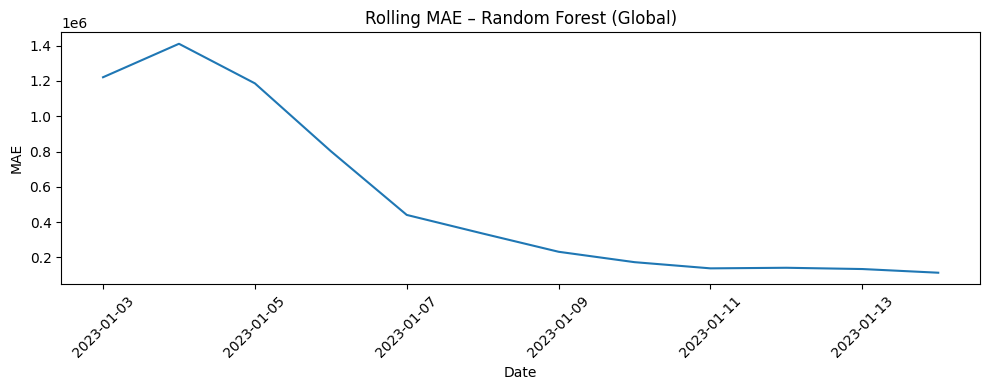

In [36]:
agg["Abs_Error_RF"] = np.abs(agg["New_cases_MA7"] - agg["Pred_RF"])
agg["Rolling_MAE_RF"] = agg["Abs_Error_RF"].rolling(3).mean()

plt.figure(figsize=(10,4))
plt.plot(agg["Date_reported"], agg["Rolling_MAE_RF"])

plt.title("Rolling MAE – Random Forest (Global)")
plt.xlabel("Date")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### HÌNH 9 — Residual distribution (3 models)

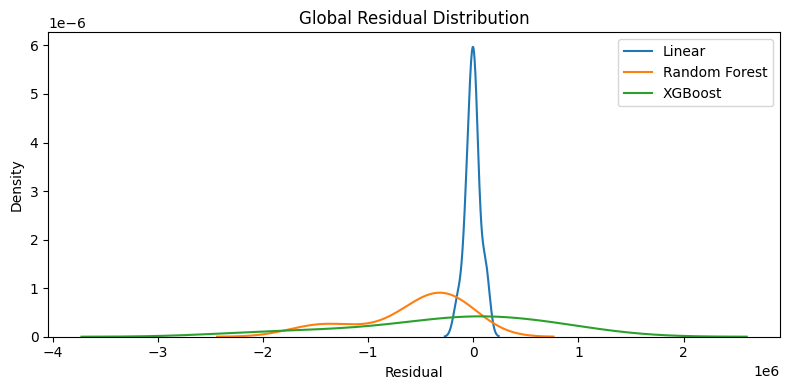

In [68]:
plt.figure(figsize=(8,4))

sns.kdeplot(agg["New_cases_MA7"] - agg["Pred_LR"], label="Linear")
sns.kdeplot(agg["New_cases_MA7"] - agg["Pred_RF"], label="Random Forest")
sns.kdeplot(agg["New_cases_MA7"] - agg["Pred_XGB"], label="XGBoost")

plt.title("Global Residual Distribution")
plt.xlabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()


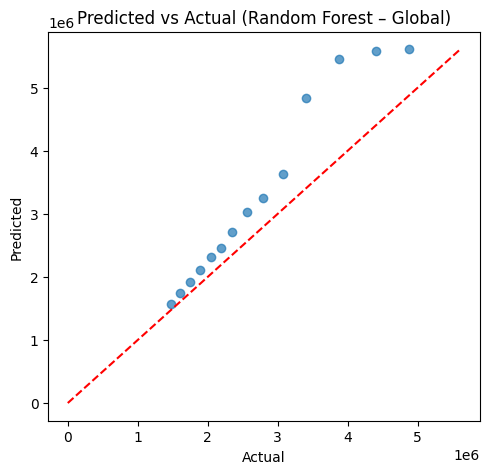

In [69]:
plt.figure(figsize=(5,5))
plt.scatter(agg["New_cases_MA7"], agg["Pred_RF"], alpha=0.7)

max_val = max(agg["New_cases_MA7"].max(), agg["Pred_RF"].max())
plt.plot([0, max_val], [0, max_val], 'r--')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Random Forest – Global)")
plt.tight_layout()
plt.show()


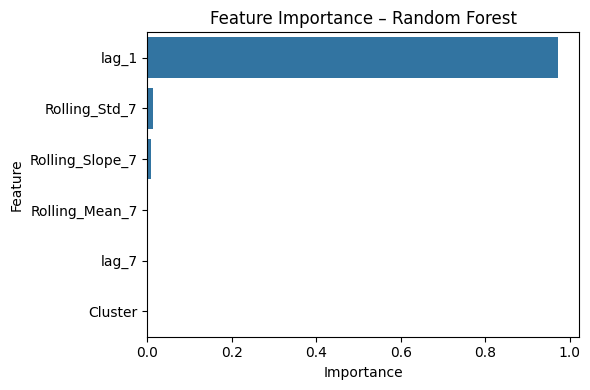

In [70]:
rf_model = models["Random Forest"]

fi_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=fi_df, x="Importance", y="Feature")
plt.title("Feature Importance – Random Forest")
plt.tight_layout()
plt.show()


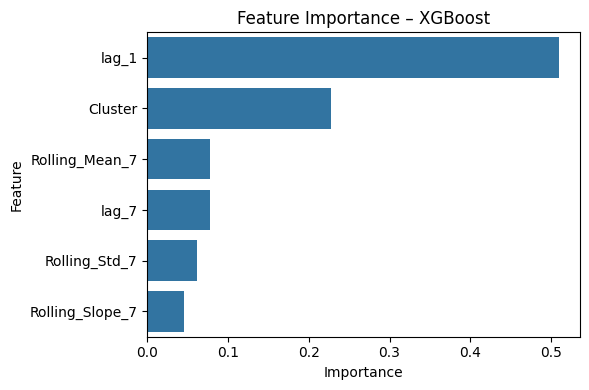

In [71]:
rf_model = models["XGBoost"]

fi_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=fi_df, x="Importance", y="Feature")
plt.title("Feature Importance – XGBoost")
plt.tight_layout()
plt.show()


C:\Users\antrn\AppData\Local\Temp\ipykernel_2328\2381492363.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df_lr, x="Importance", y="Feature", palette="vlag")


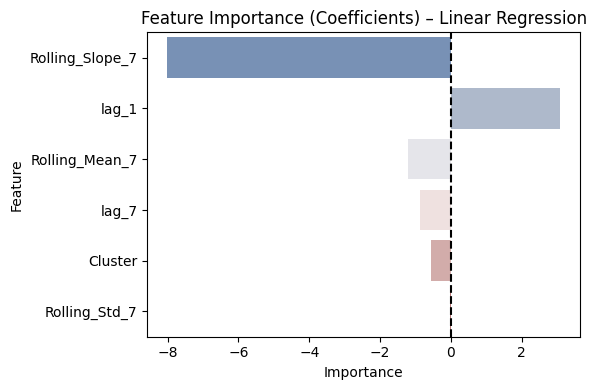

In [72]:
# Lấy mô hình Linear Regression từ dictionary của bạn
lr_model = models["Linear Regression"]

# Tạo DataFrame chứa tên biến và hệ số (coefficients) tương ứng
fi_df_lr = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": lr_model.coef_
})

# Tính giá trị tuyệt đối vì hệ số âm hay dương đều thể hiện sự quan trọng
fi_df_lr["Abs_Importance"] = fi_df_lr["Importance"].abs()
fi_df_lr = fi_df_lr.sort_values("Abs_Importance", ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(6,4))
sns.barplot(data=fi_df_lr, x="Importance", y="Feature", palette="vlag")
plt.title("Feature Importance (Coefficients) – Linear Regression")
plt.axvline(x=0, color='black', linestyle='--') # Thêm đường kẻ 0 để phân biệt âm/dương
plt.tight_layout()
plt.show()


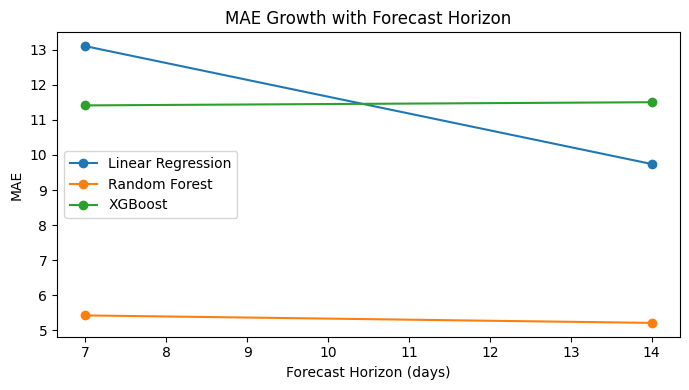

In [73]:
plt.figure(figsize=(7,4))

for model in results_df["Model"].unique():
    subset = results_df[results_df["Model"] == model]
    plt.plot(subset["Horizon (days)"], subset["MAE"],
             marker='o', label=model)

plt.title("MAE Growth with Forecast Horizon")
plt.xlabel("Forecast Horizon (days)")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()


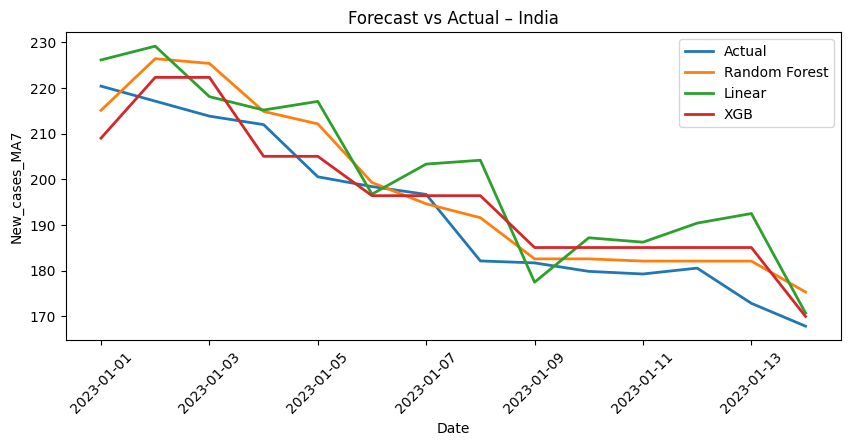

In [74]:
country = "India"

c_df = plot_df[plot_df["Country"] == country]

plt.figure(figsize=(10,4))
plt.plot(c_df["Date_reported"], c_df["New_cases_MA7"],
         label="Actual", linewidth=2)

plt.plot(c_df["Date_reported"], c_df["Pred_RF"],
         label="Random Forest", linewidth=2)

plt.plot(c_df["Date_reported"], c_df["Pred_LR"],
         label="Linear", linewidth=2)

plt.plot(c_df["Date_reported"], c_df["Pred_XGB"],
         label="XGB", linewidth=2)

plt.title(f"Forecast vs Actual – {country}")
plt.xlabel("Date")
plt.ylabel("New_cases_MA7")
plt.legend()
plt.xticks(rotation=45)
plt.show()


# Mô hình phân cụm sử dụng Random Forest


## 1. Import thư viện

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


## 2. Load Dataset

In [10]:
df = pd.read_csv("../data/processed/data_with_features.csv", parse_dates=["Date_reported"])
df = df.sort_values(["Country", "Date_reported"])


## 3. Define features

In [11]:
CLUSTER_FEATURES = [
    "lag_1",
    "lag_7",
    "Rolling_Mean_7",
    "Rolling_Slope_7",
    "Rolling_Std_7"
]

CLUSTER_TARGET = "New_cases_MA7"


## 4. Define representatives

In [12]:
cluster_representatives = {
    0: "United States of America",
    1: "India",
    2: "Israel",
    3: "Yemen",
    4: "Sweden"
}


## 5. Train models per cluster

In [13]:
cluster_rf_models = {}

for cluster_id in range(5):

    df_cluster_data = df[df["Cluster"] == cluster_id]

    cluster_train_df = df_cluster_data[
        df_cluster_data["Date_reported"] <= "2022-12-31"
    ]

    X_cluster_train = cluster_train_df[CLUSTER_FEATURES]
    y_cluster_train = cluster_train_df[CLUSTER_TARGET]

    rf_cluster_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

    rf_cluster_model.fit(X_cluster_train, y_cluster_train)

    cluster_rf_models[cluster_id] = rf_cluster_model


## 6. Evaluation function

In [14]:
def evaluate_cluster_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    return mae, rmse, mape


## 7. Evaluation per cluster

In [15]:
cluster_results = []

for cluster_id, country in cluster_representatives.items():

    df_country_cluster = df[df["Country"] == country]

    for horizon in [7, 14]:

        cluster_test_df = df_country_cluster[
            (df_country_cluster["Date_reported"] >= "2023-01-01") &
            (df_country_cluster["Date_reported"] <= f"2023-01-{horizon:02d}")
        ]

        X_cluster_test = cluster_test_df[CLUSTER_FEATURES]
        y_cluster_test = cluster_test_df[CLUSTER_TARGET]

        y_pred_cluster = cluster_rf_models[cluster_id].predict(X_cluster_test)

        mae, rmse, mape = evaluate_cluster_forecast(
            y_cluster_test, y_pred_cluster
        )

        cluster_results.append({
            "Cluster": cluster_id,
            "Country": country,
            "Horizon (days)": horizon,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape
        })

cluster_results_df = pd.DataFrame(cluster_results)
cluster_results_df


,Cluster,Country,Horizon (days),MAE,RMSE,MAPE (%)
0,0,United States of America,7,3427.606894,4348.537467,0.805220
1,0,United States of America,14,5380.253404,6389.638409,1.200824
2,1,India,7,4.585314,6.096996,2.227228
3,1,India,14,4.636693,5.647992,2.437452
4,2,Israel,7,18.432558,20.876742,1.846069
5,2,Israel,14,20.161269,23.286271,2.201777
6,3,Yemen,7,0.000000,0.000000,0.000000
7,3,Yemen,14,0.000000,0.000000,0.000000
8,4,Sweden,7,84.497090,96.286420,7.385618
9,4,Sweden,14,59.855768,73.974737,6.271420


## 8. Plot comparison

In [23]:
def plot_cluster_vs_global(country, cluster_id):

    df_country_plot = df[df["Country"] == country]

    plot_df = df_country_plot[
        (df_country_plot["Date_reported"] >= "2023-01-01") &
        (df_country_plot["Date_reported"] <= "2023-01-14")
    ].copy()

    # ===== Actual =====
    y_true = plot_df["New_cases_MA7"]

    # ===== Cluster RF =====
    X_cluster = plot_df[CLUSTER_FEATURES]
    y_pred_cluster = cluster_rf_models[cluster_id].predict(X_cluster)

    # ===== Global RF =====
    X_global = plot_df[FEATURES]
    y_pred_global = global_rf_model.predict(X_global)

    # ===== Plot =====
    plt.figure(figsize=(10,4))
    plt.plot(plot_df["Date_reported"], y_true,
             label="Actual", linewidth=2)
    plt.plot(plot_df["Date_reported"], y_pred_cluster,
             label="Cluster RF")
    plt.plot(plot_df["Date_reported"], y_pred_global,
             label="Global RF", linestyle="--")

    plt.title(f"{country} – Cluster-based vs Global Forecast")
    plt.xlabel("Date")
    plt.ylabel("New_cases_MA7")
    plt.legend()
    plt.tight_layout()
    plt.show()


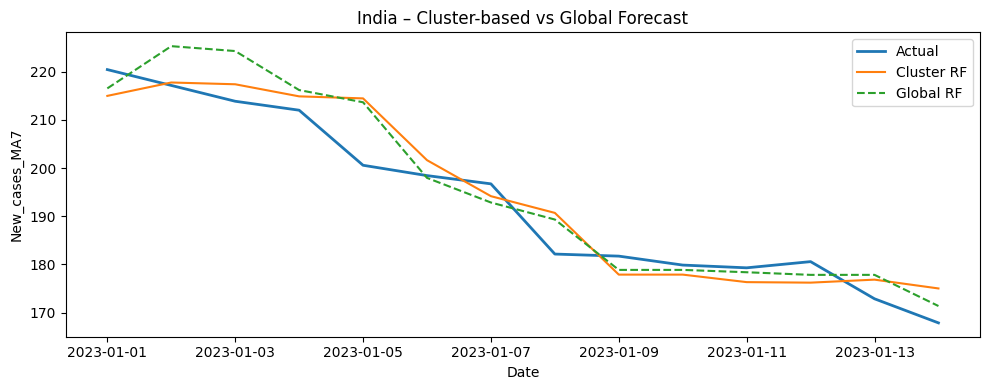

In [17]:
plot_cluster_vs_global("India", 1)

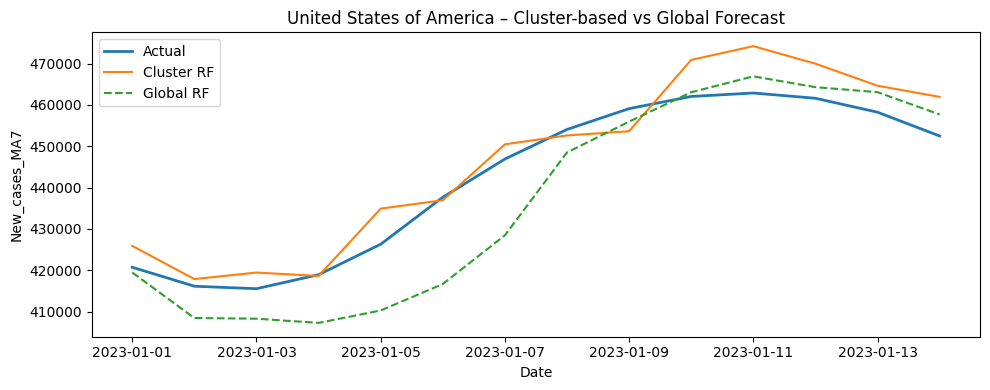

In [18]:
plot_cluster_vs_global("United States of America", 0)

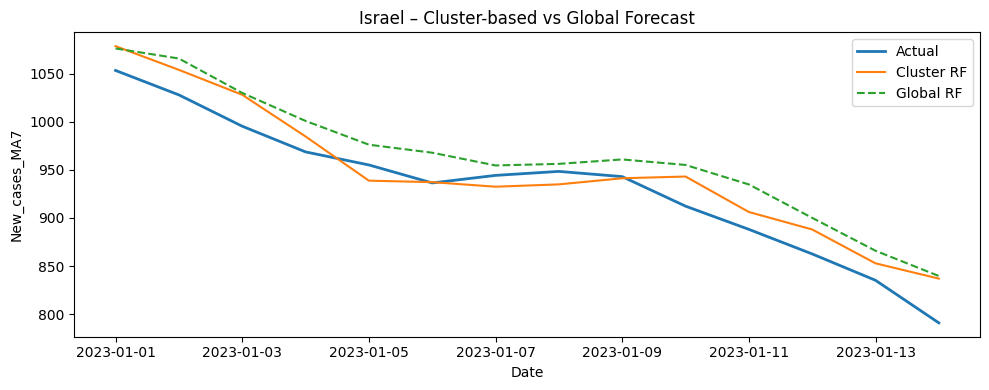

In [19]:
plot_cluster_vs_global("Israel", 2)

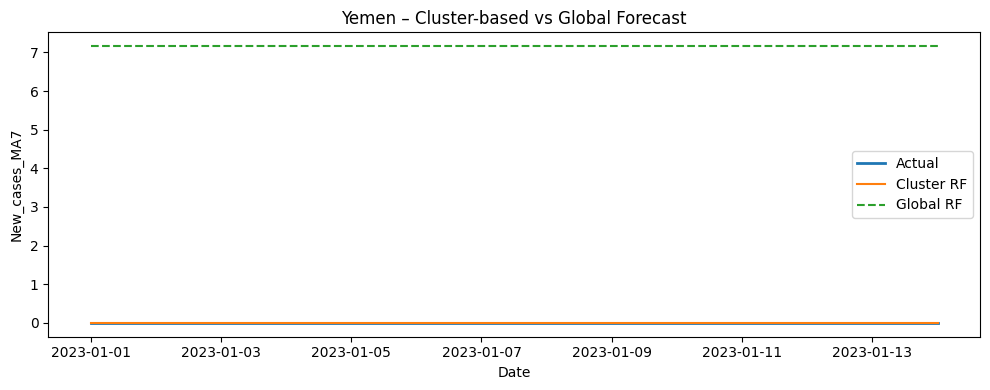

In [24]:
plot_cluster_vs_global("Yemen", 3)

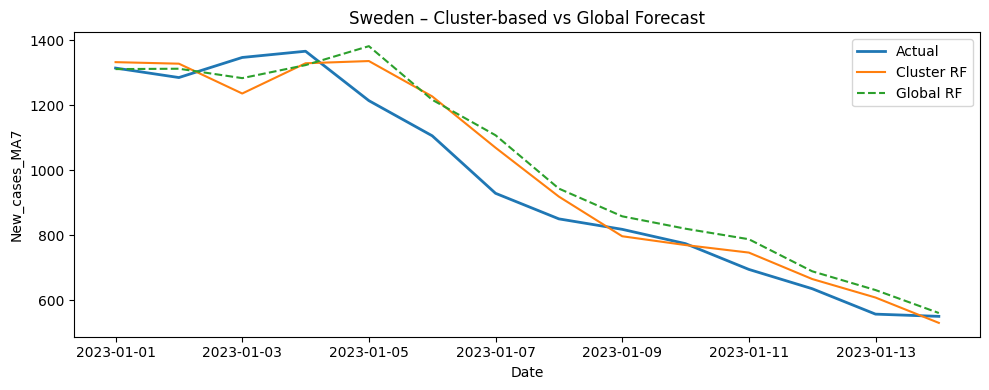

In [25]:
plot_cluster_vs_global("Sweden", 4)

In [28]:
def plot_residuals(country, cluster_id):
    
    df_plot = df[
        (df["Country"] == country) &
        (df["Date_reported"] >= "2023-01-01") &
        (df["Date_reported"] <= "2023-01-14")
    ].copy()
    
    y_true = df_plot[TARGET]
    
    # Predictions
    y_pred_global = global_rf_model.predict(df_plot[FEATURES])
    y_pred_cluster = cluster_rf_models[cluster_id].predict(df_plot[CLUSTER_FEATURES])
    
    residual_global = y_true - y_pred_global
    residual_cluster = y_true - y_pred_cluster
    
    plt.figure(figsize=(10,4))
    plt.plot(df_plot["Date_reported"], residual_global, label="Global RF Residual")
    plt.plot(df_plot["Date_reported"], residual_cluster, label="Cluster RF Residual")
    plt.axhline(0, color="black", linestyle="--", alpha=0.6)
    plt.title(f"Residual Comparison – {country}")
    plt.xlabel("Date")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.legend()
    plt.tight_layout()
    plt.show()


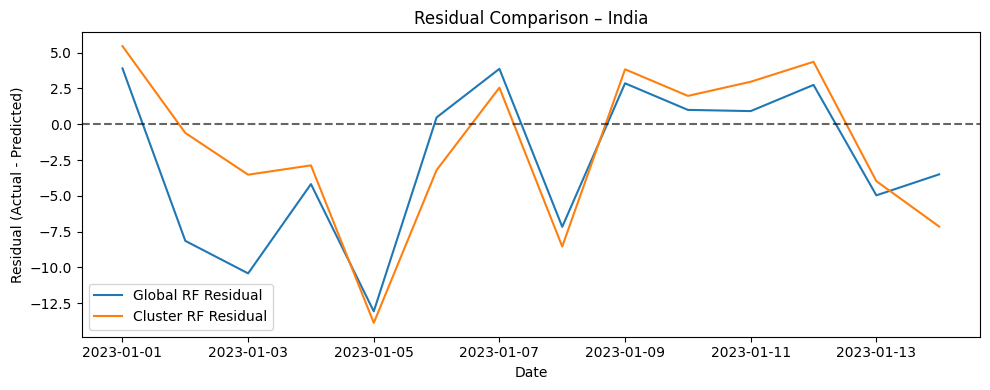

In [29]:
plot_residuals("India", 1)


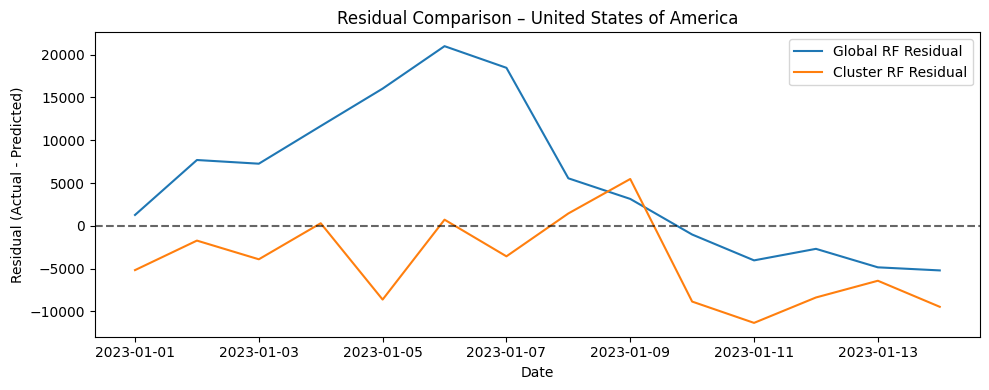

In [30]:
plot_residuals("United States of America", 0)

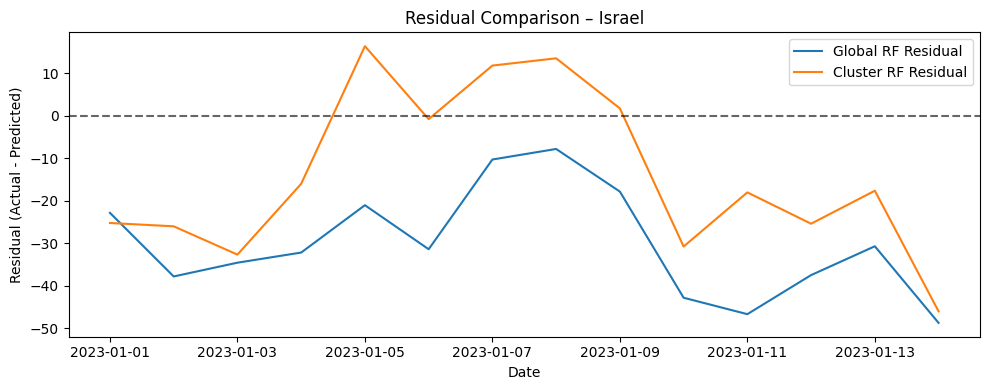

In [31]:
plot_residuals("Israel", 2)


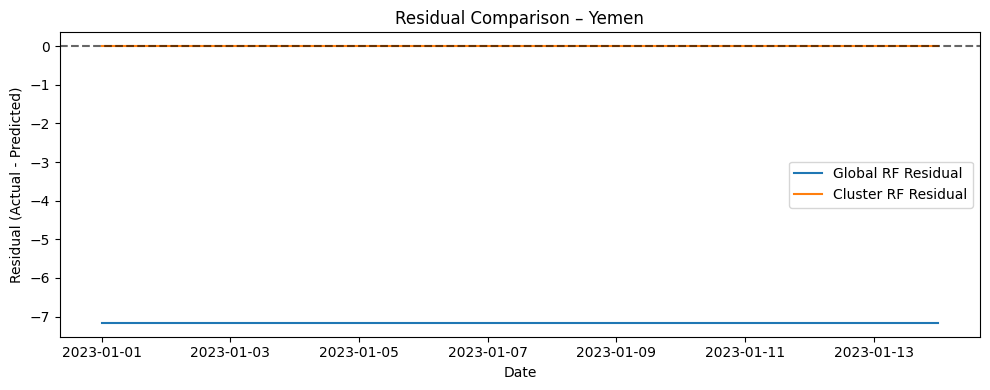

In [32]:
plot_residuals("Yemen", 3)


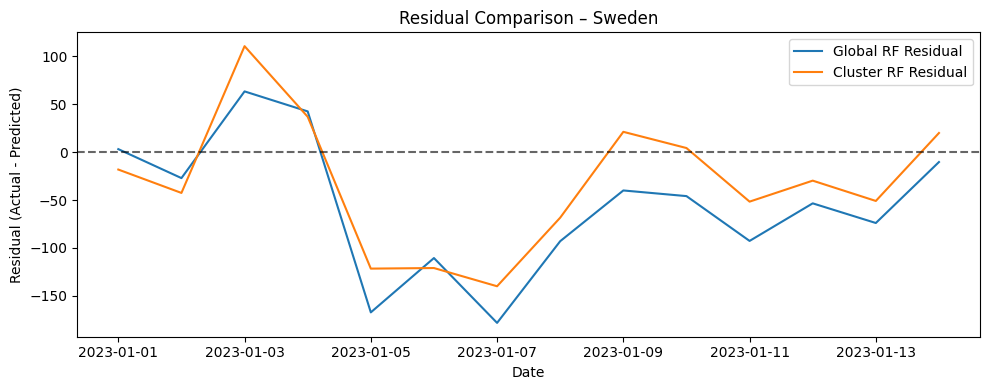

In [34]:
plot_residuals("Sweden", 4)


### (2) BAR CHART – SO SÁNH MAE / RMSE / MAPE

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    return mae, rmse, mape


In [ ]:
countries = {
    0: "United States of America",
    1: "India",
    2: "Israel",
    3: "Yemen",
    4: "Sweden"
}

metrics_rows = []

for cluster_id, country in countries.items():
    
    df_eval = df[
        (df["Country"] == country) &
        (df["Date_reported"] >= "2023-01-01") &
        (df["Date_reported"] <= "2023-01-14")
    ].copy()
    
    y_true = df_eval[TARGET]
    
    # Global RF
    X_global = df_eval[FEATURES]
    y_pred_global = global_rf_model.predict(X_global)
    
    # Cluster RF
    X_cluster = df_eval[CLUSTER_FEATURES]
    y_pred_cluster = cluster_rf_models[cluster_id].predict(X_cluster)
    
    for model_name, y_pred in zip(
        ["Global RF", "Cluster RF"],
        [y_pred_global, y_pred_cluster]
    ):
        mae, rmse, mape = compute_metrics(y_true, y_pred)
        metrics_rows.append({
            "Country": country,
            "Model": model_name,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        })

metrics_df = pd.DataFrame(metrics_rows)


In [49]:
metrics_df

,Country,Model,MAE,RMSE,MAPE
0,United States of America,Global RF,7844.331840,10010.246225,1.796553e+00
1,United States of America,Cluster RF,5380.253404,6389.638409,1.200824e+00
2,India,Global RF,4.802673,5.974298,2.439516e+00
3,India,Cluster RF,4.636693,5.647992,2.437452e+00
4,Israel,Global RF,30.195490,32.584240,3.299546e+00
5,Israel,Cluster RF,20.161269,23.286271,2.201777e+00
6,Yemen,Global RF,7.161724,7.161724,7.161724e+08
7,Yemen,Cluster RF,0.000000,0.000000,0.000000e+00
8,Sweden,Global RF,71.602792,87.879839,7.989850e+00
9,Sweden,Cluster RF,59.855768,73.974737,6.271420e+00


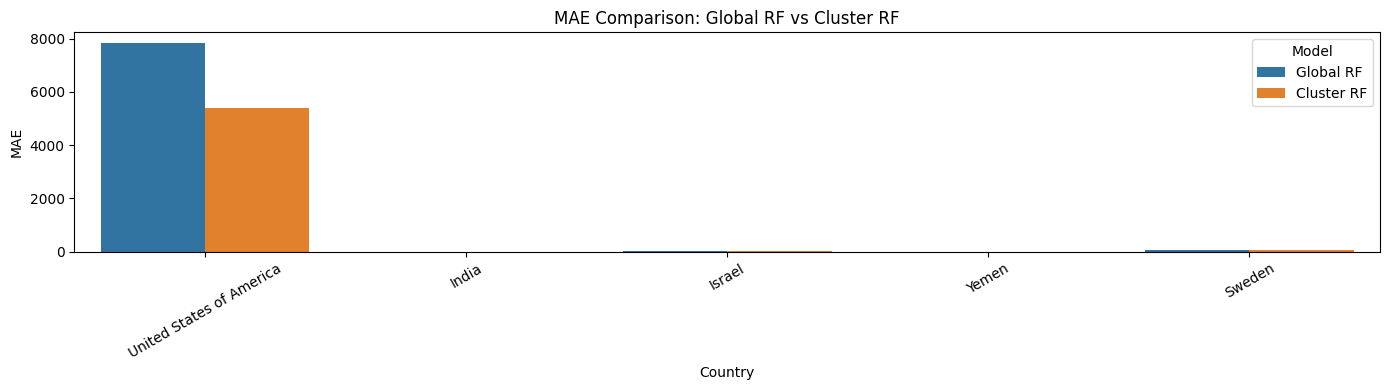

In [39]:
plt.figure(figsize=(14,4))
sns.barplot(data=metrics_df, x="Country", y="MAE", hue="Model")
plt.title("MAE Comparison: Global RF vs Cluster RF")
plt.ylabel("MAE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


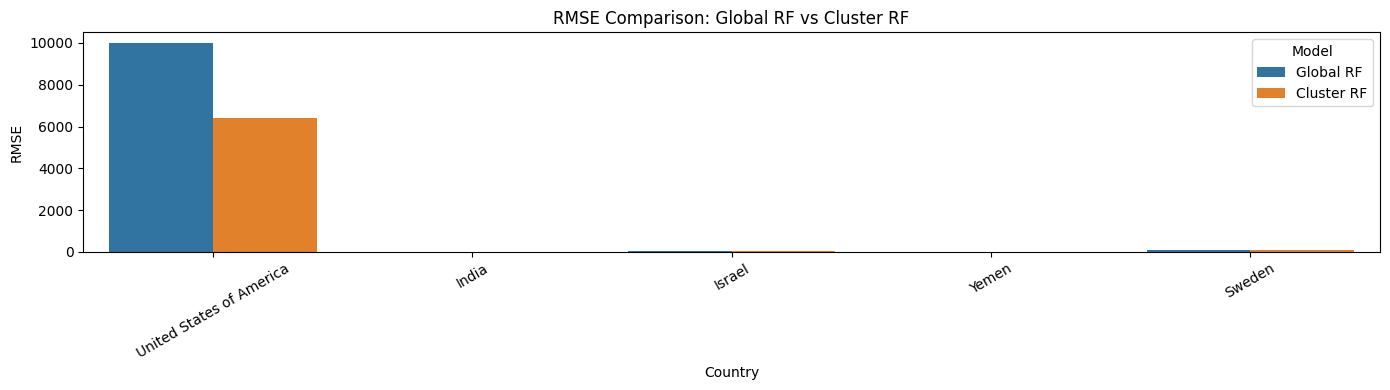

In [40]:
plt.figure(figsize=(14,4))
sns.barplot(data=metrics_df, x="Country", y="RMSE", hue="Model")
plt.title("RMSE Comparison: Global RF vs Cluster RF")
plt.ylabel("RMSE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


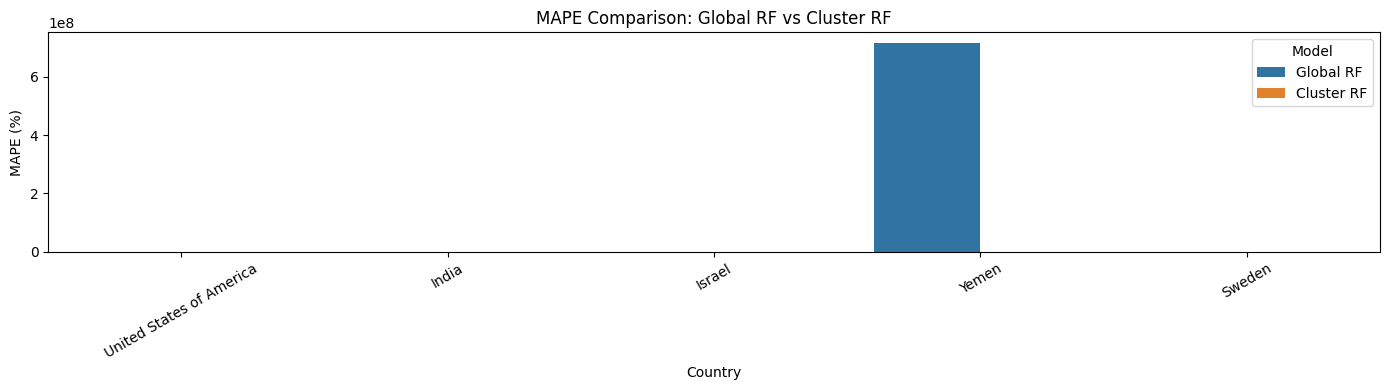

In [41]:
plt.figure(figsize=(14,4))
sns.barplot(data=metrics_df, x="Country", y="MAPE", hue="Model")
plt.title("MAPE Comparison: Global RF vs Cluster RF")
plt.ylabel("MAPE (%)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [42]:
def plot_error_distribution(country, cluster_id):
    
    df_plot = df[
        (df["Country"] == country) &
        (df["Date_reported"] >= "2023-01-01") &
        (df["Date_reported"] <= "2023-01-14")
    ].copy()
    
    y_true = df_plot[TARGET]
    
    y_pred_global = global_rf_model.predict(df_plot[FEATURES])
    y_pred_cluster = cluster_rf_models[cluster_id].predict(df_plot[CLUSTER_FEATURES])
    
    error_global = y_true - y_pred_global
    error_cluster = y_true - y_pred_cluster
    
    plt.figure(figsize=(10,4))
    sns.kdeplot(error_global, label="Global RF", fill=True)
    sns.kdeplot(error_cluster, label="Cluster RF", fill=True)
    plt.axvline(0, color="black", linestyle="--", alpha=0.6)
    plt.title(f"Error Distribution – {country}")
    plt.xlabel("Prediction Error")
    plt.legend()
    plt.tight_layout()
    plt.show()


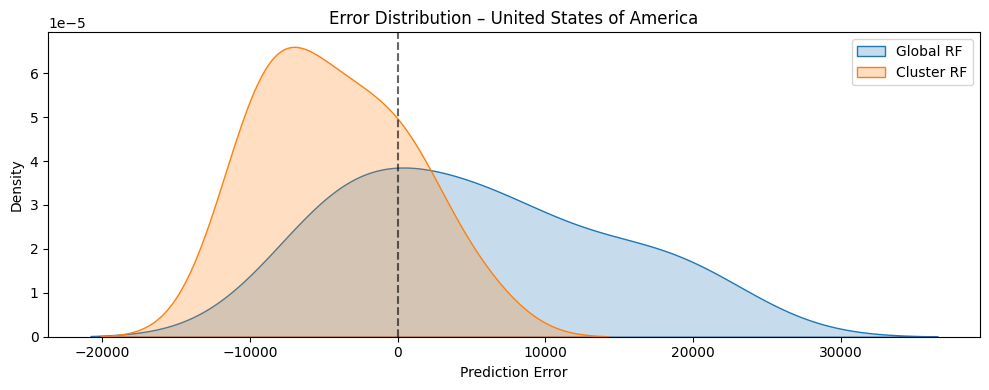

In [44]:
plot_error_distribution("United States of America", 0)


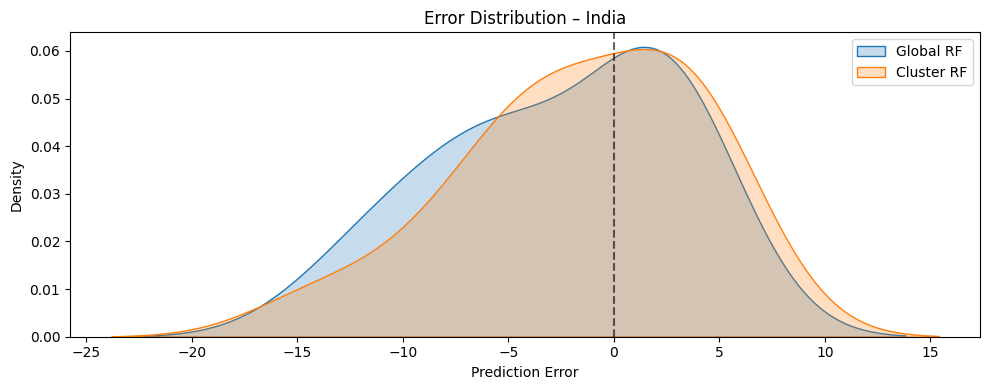

In [45]:
plot_error_distribution("India", 1)


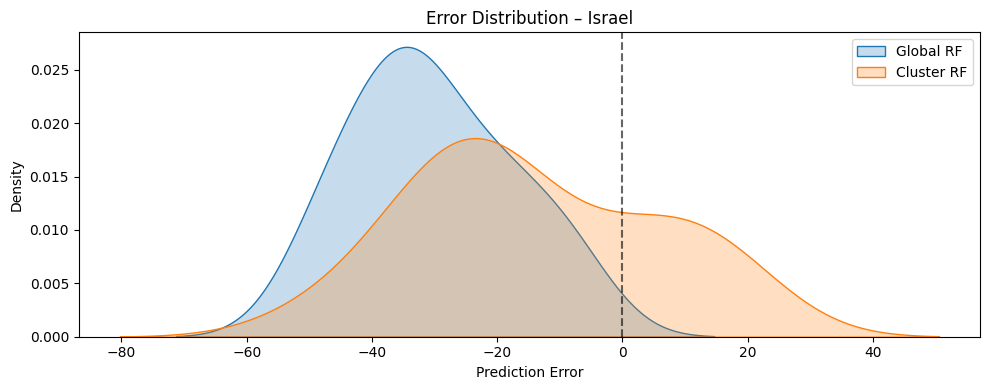

In [48]:
plot_error_distribution("Israel", 2)


C:\Users\antrn\AppData\Local\Temp\ipykernel_2328\3844610459.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(error_cluster, label="Cluster RF", fill=True)


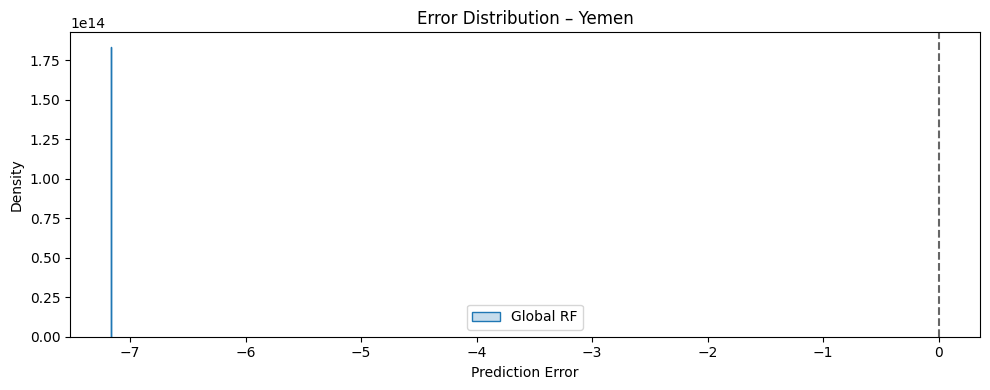

In [47]:
plot_error_distribution("Yemen", 3)


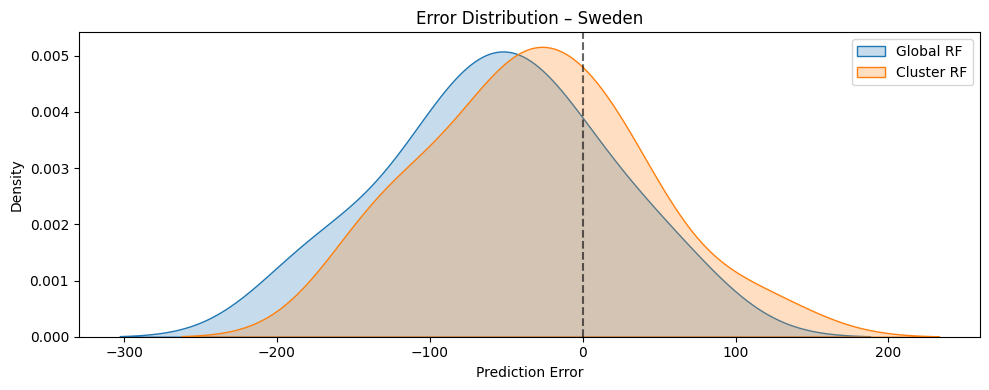

In [46]:
plot_error_distribution("Sweden", 4)
